# Setting

In [1]:
import os
from typing import List, Dict, Union

import polars as pl

from scripts.metrics import map_at_k

In [2]:
INPUT_DIR = "../../input/raw/"
OUTPUT_DIR = "./candidates/"

In [3]:
def explode_and_add_seq_no(df:pl.DataFrame) -> pl.DataFrame:
    df = df.explode(["prev_items"])
    df = df.with_columns(
        df.select(pl.col("session_id").cumcount().over("session_id").alias("seq_no").cast(pl.Int64))
    )
    return df

In [4]:
def generate_co_visit_matrix(df:pl.DataFrame) -> pl.DataFrame:
    # 2-hop先までの共起ペアの作成
    one_hop = df.join(df, on="session_id")
    one_hop = one_hop.filter(pl.col("yad_no") != pl.col("yad_no_right"))[["yad_no", "yad_no_right"]]
    two_hop = one_hop.join(one_hop, left_on="yad_no_right", right_on="yad_no")
    two_hop = two_hop.filter(pl.col("yad_no") != pl.col("yad_no_right_right"))

    # yad_noのペアごとに共起回数を計算
    df = two_hop.group_by(["yad_no", "yad_no_right_right"]).count()

    # rankを計算
    df = df.with_columns(
        pl.col("count").rank(descending=True).over("yad_no").alias("two_hop_co_visit_weight_rank")
    ).filter(
        pl.col("two_hop_co_visit_weight_rank") <= 100
    )

    # 整形
    df = df.rename({"yad_no_right_right":"candidate_yad_no"})[["yad_no", "candidate_yad_no", "two_hop_co_visit_weight_rank"]]

    return df

# For local train/eval

In [5]:
train_log = pl.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
test_log = pl.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))

In [6]:
log = pl.concat([train_log, test_log], how="vertical")

In [7]:
co_visit_matrix = generate_co_visit_matrix(log)

In [8]:
co_visit_matrix.write_parquet(os.path.join(OUTPUT_DIR, "two_hop_co_visit_matrix_for_train_or_eval.parquet"))

In [9]:
co_visit_matrix.head()

yad_no,candidate_yad_no,two_hop_co_visit_weight_rank
i64,i64,f64
10915,96,2.0
11380,898,4.0
4072,898,8.0
12491,898,3.0
7014,143,1.0


In [10]:
co_visit_matrix.describe()

describe,yad_no,candidate_yad_no,two_hop_co_visit_weight_rank
str,f64,f64,f64
"""count""",468982.0,468982.0,468982.0
"""null_count""",0.0,0.0,0.0
"""mean""",6871.04062,6905.902412,33.179845
"""std""",3987.512021,4004.17313,26.007711
"""min""",1.0,1.0,1.0
"""25%""",3418.0,3414.0,11.5
"""50%""",6836.0,6853.0,26.5
"""75%""",10324.0,10385.0,50.0
"""max""",13806.0,13806.0,100.0


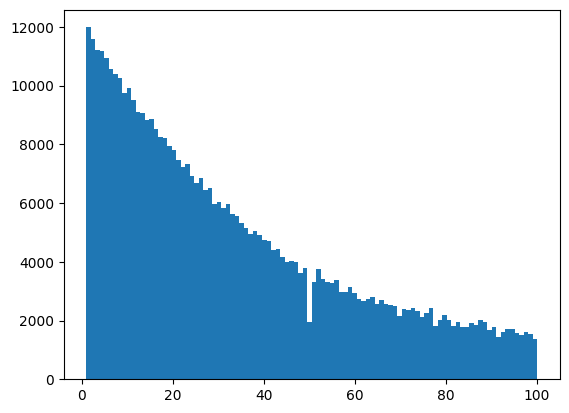

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(co_visit_matrix["two_hop_co_visit_weight_rank"], bins=100)
fig.show()

# MAP@k=10

In [12]:
train_log = pl.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label = pl.read_csv(os.path.join(INPUT_DIR, "train_label.csv")).rename({"yad_no":"label_yad_no"})

In [13]:
last_items = train_log.group_by("session_id").last()

In [14]:
co_visit_matrix = pl.read_parquet(os.path.join(OUTPUT_DIR, "two_hop_co_visit_matrix_for_train_or_eval.parquet"))

In [15]:
prediction = last_items \
    .join(co_visit_matrix, on="yad_no", how="left") \
    .join(train_label, on="session_id", how="left") \
    .sort(["session_id", "two_hop_co_visit_weight_rank"], descending=[False, False]) \
    .with_columns((pl.col("candidate_yad_no") == pl.col("label_yad_no")).cast(pl.Int8).alias("user_relevance")) \
    .fill_null(0)

In [16]:
user_relevances = prediction.group_by("session_id", maintain_order=True).all()["user_relevance"].to_list()

In [17]:
map_at_k(user_relevances, 10)

0.16088189784084805

# For test

In [18]:
train_log = pl.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label = pl.read_csv(os.path.join(INPUT_DIR, "train_label.csv"))
test_log = pl.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))

In [19]:
# trainのlabelをlogにappendする

prev_items_list = (
    train_log
    .sort(["session_id", "seq_no"])
    .group_by("session_id", maintain_order=True)
    .agg(pl.col("yad_no"))
)["yad_no"].to_list()

next_item_list = (
    train_label
    .sort("session_id")
)["yad_no"].to_list()

prev_items_list_updated = []
for prev_items, next_item in zip(prev_items_list, next_item_list):
    prev_items.append(next_item)
    prev_items_list_updated.append(prev_items)

train_log = train_label.with_columns(
    pl.Series(name="prev_items", values=prev_items_list_updated)
)

train_log = explode_and_add_seq_no(train_log) \
    .drop("yad_no") \
    .rename({"prev_items" : "yad_no"}) \
    [["session_id", "seq_no", "yad_no"]] # カラム並び替え

In [20]:
log = pl.concat([train_log, test_log], how="vertical")

In [ ]:
co_visit_matrix = generate_co_visit_matrix(log)

In [ ]:
co_visit_matrix.write_parquet(os.path.join(OUTPUT_DIR, "two_hop_co_visit_matrix_for_test.parquet"))

In [ ]:
co_visit_matrix.head()

In [ ]:
co_visit_matrix.describe()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(co_visit_matrix["two_hop_co_visit_weight_rank"], bins=100)
fig.show()